In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
import scipy
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

from netCDF4 import Dataset


## towards a numba way of evaluating gamma distributions

need to evaluate alpha (shape), beta (scale), and fraction zero params

beta is a function of <x\> and alpha; alpha is function of ln(<x\>) and <ln(x)>, with <x\> for x>0


1. for a given month+bookends, read in 3 hourly MSWEP data.

Then, EITHER

2. at each grid point, sum precip values for all 3 hourly files --> this could be an IO nightmare? perhaps open each serially instead of mf_dataset?
    - check for small values (e.g., precip < .254 mm) & set to 0
    - record # of precip >0 days and precip = 0 days

OR

3.  open bookended months, sum along time dimension, query precip > 0, =0 --> natural log sum/N>0, av natural log >0
4. compute D statistic --> alpha, beta, fraction 0

need to have prep area to cleanly gather correct months/days, since everything in day-of-year. since we only care about sums i don't think we need to keep track of days after that?

Gather all data belonging to chosen month, spanning the years 2002-2023. Data will be supplemented by "book-ending" months. So, for example, gathering data for the month of June will include May and July precip data as well. 

In [2]:
month = 6
domain = 'co'


file_list = []

for i in range(2019, 2024):
    chosen_date = datetime.datetime(year=i, month=month, day=1)
    #logic for determining prev/next months
    if month == 1:
        prev_month = 12
        prev_year = i-1
        next_month = month+1
        next_year = i
    elif month == 12:
        prev_month = month-1
        prev_year = i
        next_month = 1
        next_year = i+1
    else:
        prev_month = month-1
        prev_year = i
        next_month = month+1
        next_year = i

    #determine which days of year correspond to chosen month
    date_touples = [(prev_month, prev_year), (month, i), (next_month, next_year)]
    for datet in date_touples:
        m, y = datet[0], datet[1]
        dt = datetime.datetime(year=y, month=m, day=1)
        this_doy = dt.strftime('%Y%j')
        start = int(this_doy[4:])
        end = start+pd.Period(f'{y}-{m}-1').daysinmonth-1
        path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{y}/"
        expected_files = [path+f"{y}"+"{}.*.nc".format(j) for j in range(start, end+1)]
        for file_ in expected_files:
            file_list.append(sorted(glob(file_)))

mswep_paths = [
    x
    for xs in file_list
    for x in xs
]

In [3]:
len(mswep_paths)

3680

In [4]:
from numba import jit

@jit
def NUMBA_increment_gamma_components(apcp,npositive,nzero,xsum,xsumln,thresh=0.0):
    y, x = np.shape(apcp)
    for dx in range(x):
        for dy in range(y):
            if apcp[dy, dx] <= thresh:
                nzero[dy, dx] += 1
            else:  #apcp[dy, dx] > thresh:
                npositive[dy, dx] += 1
                xsum[dy, dx] += apcp[dy, dx]
                xsumln[dy, dx] += np.log(apcp[dy, dx])
    return npositive, nzero, xsum, xsumln
    
    

In [5]:
ds = Dataset(mswep_paths[0],mode="r")
nx = ds.dimensions['x'].size
ny = ds.dimensions['y'].size
ds.close()

In [68]:
def open_and_sum(chunk_start, chunk_size):
    
    #i don't like relying on global vars, but alas
    #if (chunk_start+chunk_size) > len(mswep_paths):
    #    end=-1#i need to think about this, because if all apcp_sums are not the same size (same # of days)
    #    #i think numpy gets mad...
    #else:
    end = chunk_size + chunk_start
    this_chunk_files = mswep_paths[chunk_start:end]
    
    #(days, lat, lon)
    num_days = int(len(this_chunk_files)/8)
    apcp_sums = np.zeros((num_days, ny,nx),dtype=np.float32)
    
    #break it down by day since we only want to sum over 24 hours --> 8 files in a day
    for days in range(num_days):
        doy_sums = np.zeros((ny,nx),dtype=np.float32)
        for hour in range(8):
            f = this_chunk_files[(8*days)+hour]
            ds = Dataset(f, mode='r')
            apcp_var = ds.variables['precipitation']
            apcp = np.asarray(apcp_var[0])
            ds.close()
            doy_sums += apcp
        apcp_sums[days, :, :] = doy_sums
    return apcp_sums



In [7]:
total_files = len(mswep_paths)
total_days = int(total_files / 8)

In [8]:
total_days 

460

In [36]:
total_days/23

20.0

In [35]:
t=np.arange(2,total_days,1)
t[total_days%t==0]

array([  2,   4,   5,  10,  20,  23,  46,  92, 115, 230])

In [37]:
chunk_size=20*8 #--> total number of files per cpu

In [72]:
chunk_size

160

In [39]:
chunk_start=np.arange(0, total_files,chunk_size)

In [40]:
chunk_start[-1] + chunk_size

3680

In [14]:
len(mswep_paths)

3680

In [41]:
len(chunk_start)

23

In [29]:
import multiprocessing

In [69]:
start = datetime.datetime.now()
with multiprocessing.Pool(25) as P:
    out = P.starmap(open_and_sum, zip(chunk_start,np.repeat(chunk_size, len(chunk_start))))
end=datetime.datetime.now()

print(f"Finished in {(end-start).total_seconds()}")

Finished in 32.649699


In [71]:
np.shape(out)

(23, 20, 1597, 2345)

In [98]:
@jit
def NUMBA_increment_gamma_components(apcp,thresh=0.0):
    y, x = np.shape(apcp)[1], np.shape(apcp)[2]

    npositive = np.zeros((ny,nx),dtype=np.int32)
    nzero = np.zeros((ny,nx),dtype=np.int32)
    xsum = np.zeros((ny,nx),dtype=np.float32)
    xsumln = np.zeros((ny,nx),dtype=np.float32)
    for day in range(np.shape(apcp)[0]):
        for dx in range(x):
            for dy in range(y):
                if (apcp[day, dy, dx] <= thresh) and (apcp[day, dy, dx] > 0.0):
                    nzero[dy, dx] += 1
                elif (apcp[day,dy, dx] > thresh) and (apcp[day,dy,dx] > 0.0):
                    npositive[dy, dx] += 1
                    xsum[dy, dx] += apcp[day,dy, dx]
                    xsumln[dy, dx] += np.log(apcp[day,dy, dx])
    return npositive, nzero, xsum, xsumln

In [74]:
apcp_by_day=np.asarray(out).reshape(len(chunk_start)*int(chunk_size/8), 1597, 2345)

In [99]:
npositive,nzero,xsum,xsumln = NUMBA_increment_gamma_components(apcp_by_day,thresh=0.254)

In [124]:
@jit
def compute_gamma_params(npos, nz, xsum, xsumln):
    DEFAULT_MISSING = -9999.
    
    alpha = np.zeros_like(npos,dtype=np.float32)
    beta = np.zeros_like(npos,dtype=np.float32)
    fz = np.zeros_like(npos,dtype=np.float32)
    ny, nx = np.shape(alpha)
    got_here=1
    for i in range(ny):
        for j in range(nx):
            if npos[i,j] >= 1:
                average = xsum[i,j] / npos[i,j]
                average_of_log = (1.0 / npos[i,j]) * xsumln[i,j]
                dstat = np.log(average) - average_of_log
                alpha[i,j] = (1.0 + (np.sqrt(1.0 + ((4.0 * dstat) / 3.0)))) / (4.0 * dstat)
                if (alpha[i,j] <= 0.0) or (np.isfinite(alpha[i,j]) == False):
                    alpha[i,j] = DEFAULT_MISSING
                    beta[i,j] = DEFAULT_MISSING
                else:
                    beta[i,j] = average / alpha[i,j]
            else:
                alpha[i,j] = DEFAULT_MISSING
                beta[i,j] = DEFAULT_MISSING
            
            if ((nz[i,j] + npos[i,j]) <= 0):
                fz[i,j] = DEFAULT_MISSING
            else:
                fz[i,j] = (nz[i,j] / (nz[i,j] + npos[i,j]))
    return alpha, beta, fz


In [125]:
alpha,beta,fraczero = compute_gamma_params(npositive,nzero,xsum,xsumln)

In [138]:
DEFAULT_MISSING = -9999.

In [137]:
ncoutput = '/scratch2/STI/mdl-sti/Sidney.Lower/scripts/Supplemental_Locations/test_out_gamma_params.nc'

ds = Dataset(mswep_paths[0],mode="r")

dsout = Dataset(ncoutput,mode="w",format="NETCDF4")
xdim = dsout.createDimension("x",nx)
ydim = dsout.createDimension("y",ny)
for name in ['latitude','longitude']:
    var = ds.variables[name]
    varout = dsout.createVariable(name,var.datatype,var.dimensions,
            zlib=True,complevel=4,chunksizes=tuple(var.chunking()))
    varout.setncatts(var.__dict__)
    varout[:,:] = var[:,:]
    ds.sync()

In [140]:
alpha_var = dsout.createVariable("alpha","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
alpha_var.long_name = "Gamma Alpha (Shape) Parameter"
alpha_var.missing_value = np.float32(DEFAULT_MISSING)
alpha_var.coordinates = "longitude latitude"

beta_var = dsout.createVariable("beta","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
beta_var.long_name = "Gamma Beta (Scale) Parameter"
beta_var.missing_value = np.float32(DEFAULT_MISSING)
beta_var.coordinates = "longitude latitude"

fz_var = dsout.createVariable("fraction_zero","f4",("y","x"),
            zlib=True,complevel=4,chunksizes=(ny,nx))
fz_var.long_name = "Fraction Zero"
fz_var.missing_value = np.float32(DEFAULT_MISSING)
fz_var.coordinates = "longitude latitude"

In [141]:
alpha_var[:,:] = alpha
beta_var[:,:] = beta
fz_var[:,:] = fraczero
dsout.sync()
dsout.close()

In [142]:
test = xr.open_dataset('test_out_gamma_params.nc')

In [143]:
test

<xarray.Dataset>
Dimensions:        (y: 1597, x: 2345)
Coordinates:
    latitude       (y, x) float32 ...
    longitude      (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    alpha          (y, x) float32 ...
    beta           (y, x) float32 ...
    fraction_zero  (y, x) float32 ...

In [150]:
test.alpha

<xarray.DataArray 'alpha' (y: 1597, x: 2345)>
array([[1.261217, 1.267261, 1.278418, ..., 0.897713, 0.898314, 0.896752],
       [1.235398, 1.247034, 1.260413, ..., 0.876558, 0.884563, 0.892839],
       [1.224576, 1.236481, 1.249356, ..., 0.865648, 0.869037, 0.871682],
       ...,
       [0.878192, 0.875371, 0.869708, ..., 0.98577 , 0.961719, 0.935745],
       [0.874393, 0.876587, 0.871343, ..., 0.94647 , 0.946971, 0.929048],
       [0.875789, 0.868093, 0.859583, ..., 0.946722, 0.940347, 0.92494 ]],
      dtype=float32)
Coordinates:
    latitude   (y, x) float32 19.23 19.23 19.24 19.24 ... 54.38 54.38 54.37
    longitude  (y, x) float32 233.7 233.7 233.8 233.8 ... 300.9 300.9 301.0
Dimensions without coordinates: y, x
Attributes:
    long_name:  Gamma Alpha (Shape) Parameter

In [154]:
g = np.ravel(test.alpha.data)

(array([0.000000e+00, 1.300000e+01, 6.434000e+04, 1.551403e+06,
        1.498310e+06, 3.024470e+05, 7.086600e+04, 2.799400e+04,
        1.942700e+04, 1.676000e+04, 1.445000e+04, 1.436600e+04,
        1.433700e+04, 1.437900e+04, 1.422600e+04, 1.229000e+04,
        1.041100e+04, 9.460000e+03, 9.204000e+03, 8.536000e+03,
        8.152000e+03, 8.142000e+03, 7.748000e+03, 6.728000e+03,
        5.155000e+03, 4.360000e+03, 3.792000e+03, 3.246000e+03,
        2.661000e+03, 2.669000e+03, 2.400000e+03, 1.937000e+03,
        1.697000e+03, 1.364000e+03, 1.214000e+03, 1.063000e+03,
        9.500000e+02, 7.930000e+02, 6.930000e+02, 5.640000e+02,
        5.150000e+02, 4.290000e+02, 3.770000e+02, 3.420000e+02,
        3.170000e+02, 2.750000e+02, 2.540000e+02, 2.510000e+02,
        2.000000e+02, 1.950000e+02]),
 array([ 0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ,  1.20000005,  1.39999998,  1.60000002,  1.79999995,
         2.        ,  2.20000005,  2.4000001 ,  

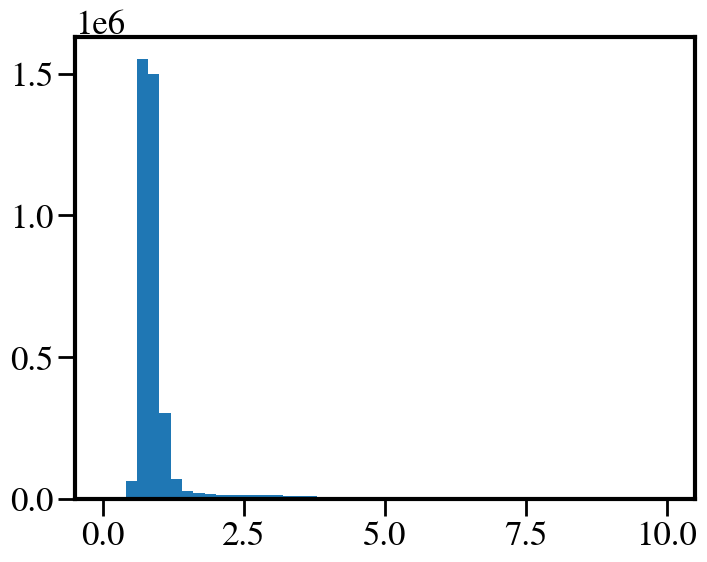

In [155]:
plt.hist(g, range=(0,10), bins=50)

In [148]:
from mpl_toolkits.basemap import Basemap

{230.0: ([<matplotlib.lines.Line2D at 0x154c2d05b2b0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x154c2d05b520>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x154c2d05b7c0>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x154c2d05ba60>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x154c2d05bd00>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x154c2d05bfa0>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x154c2d098280>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x154c2d098520>], [])}

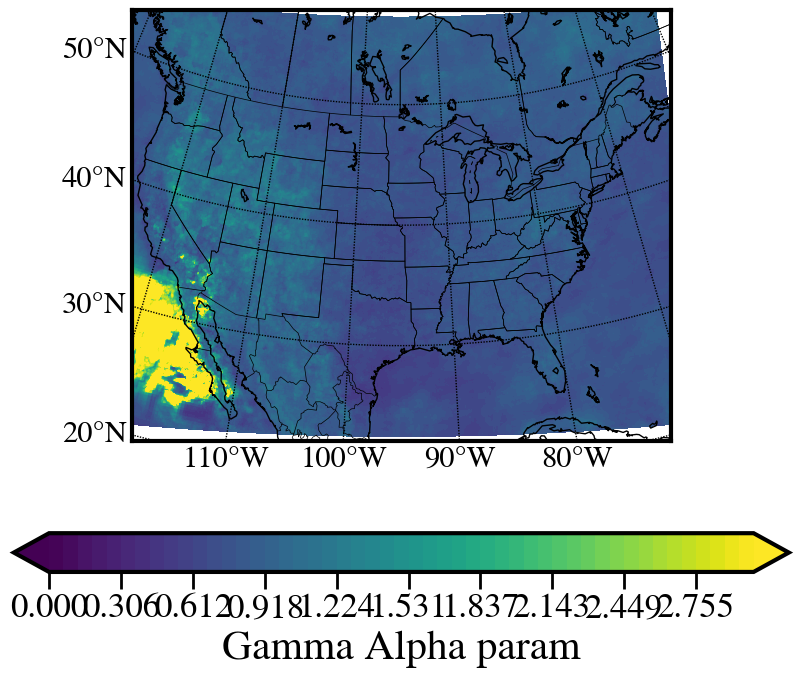

In [156]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_alpha = np.linspace(0,3,50)

#GEFS
lats, lons = test.latitude.data, test.longitude.data
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,test.alpha.data,extend='both',ax=axes,levels= clevs_alpha,cmap=cm.viridis)
cbar=plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Gamma Alpha param')
#cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [157]:
b = np.ravel(test.beta.data)

(array([2.11214e+05, 7.43430e+04, 6.01900e+04, 6.30740e+04, 7.68240e+04,
        1.10367e+05, 1.41335e+05, 1.65874e+05, 1.52000e+05, 1.41050e+05,
        1.65404e+05, 2.15161e+05, 2.32032e+05, 1.80049e+05, 1.69671e+05,
        1.68185e+05, 1.64249e+05, 1.52965e+05, 1.39626e+05, 1.32661e+05,
        1.20658e+05, 1.07490e+05, 9.74050e+04, 7.89190e+04, 6.38530e+04,
        5.49820e+04, 4.58290e+04, 3.96800e+04, 3.42910e+04, 2.85550e+04,
        2.52660e+04, 2.23500e+04, 2.02510e+04, 1.90440e+04, 1.66730e+04,
        1.36510e+04, 1.12850e+04, 8.48800e+03, 6.20000e+03, 3.71300e+03,
        2.80800e+03, 2.17300e+03, 1.63100e+03, 1.15800e+03, 7.78000e+02,
        4.85000e+02, 3.34000e+02, 2.02000e+02, 1.18000e+02, 1.12000e+02]),
 array([ 0.        ,  0.40000001,  0.80000001,  1.20000005,  1.60000002,
         2.        ,  2.4000001 ,  2.79999995,  3.20000005,  3.5999999 ,
         4.        ,  4.4000001 ,  4.80000019,  5.19999981,  5.5999999 ,
         6.        ,  6.4000001 ,  6.80000019,  7

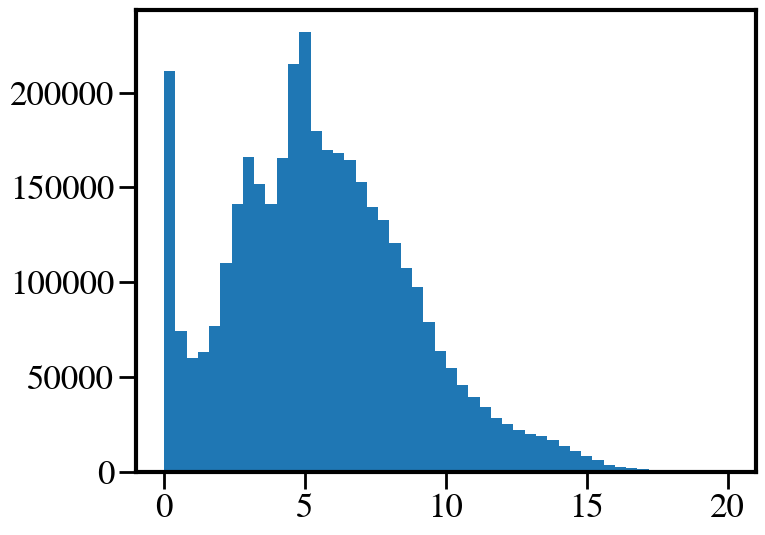

In [159]:
plt.hist(b, range=(0,20), bins=50)

{230.0: ([<matplotlib.lines.Line2D at 0x154d81313130>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x154d813133a0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x154d81313640>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x154d813138e0>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x154d81313b80>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x154d81313e20>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x154d81354100>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x154d813543a0>], [])}

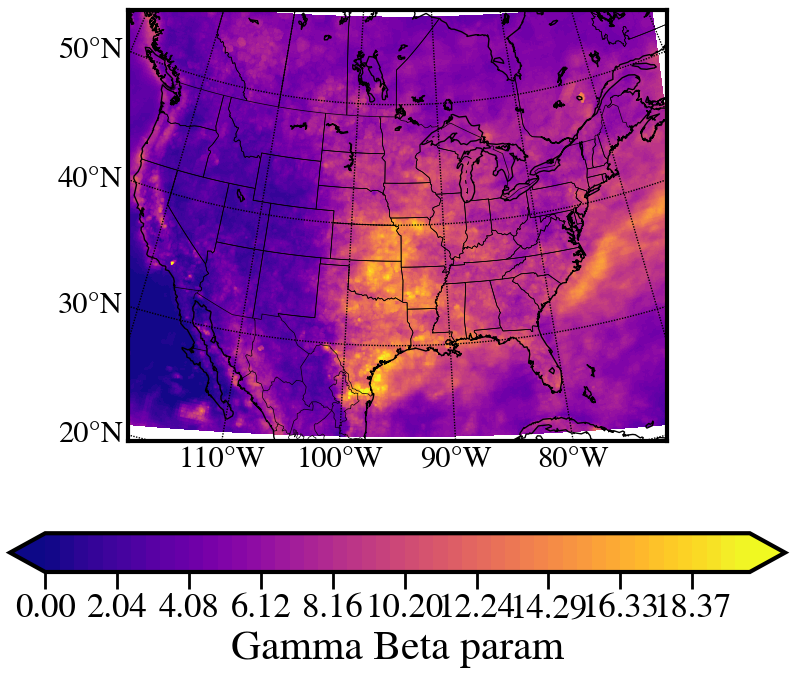

In [161]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_beta = np.linspace(0,20,50)

#GEFS
lats, lons = test.latitude.data, test.longitude.data
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,test.beta.data,extend='both',ax=axes,levels= clevs_beta,cmap=cm.plasma)
cbar=plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Gamma Beta param')
#cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

## testing MSWEP APCP values

In [79]:
test_paths = ['/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.00.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.03.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.06.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.09.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.12.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.15.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.18.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002121.21.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002122.00.nc',
 '/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2002/2002122.03.nc']

In [80]:
ds = Dataset(test_paths[4], mode='r')

In [81]:
apcp_var = ds.variables['precipitation']
apcp = apcp_var[0,:,:]

In [82]:
np.where(apcp == 1.0)

(array([ 469,  572,  573,  596,  596,  596,  596,  597,  597,  597,  597,
         598,  598,  598,  599,  599,  599,  600,  617,  639,  639,  639,
         640,  640,  640,  640,  641,  641,  641,  641,  642,  642,  642,
         642,  643,  643,  643,  774,  775,  775,  775,  775,  775,  775,
         776,  776,  776,  776,  776,  776,  776,  777,  777,  777,  777,
         777,  777,  777,  778,  778,  778,  778,  778,  778,  778,  779,
         779,  779,  779,  779,  779,  779,  779,  780,  780,  780,  780,
         780,  780,  780,  781,  781,  781,  781,  781,  781,  781,  782,
         782,  782,  782,  782,  782,  782,  783,  783,  783,  783,  783,
         783,  783,  784,  784,  784,  784,  784,  784,  784,  784,  785,
         785,  785,  785,  785,  785,  785,  786,  786,  786,  786,  786,
         786,  786,  787,  787,  787,  787,  787,  787,  787,  788,  788,
         788,  788,  788,  788,  788,  789,  789,  789,  789,  789,  789,
         789,  789,  790,  790,  790, 

In [84]:
#if apcp = 1 at a grid point, then

npos = 1.
xsum = 1.
xsumln = np.log(xsum)

In [85]:
dstat = np.log(xsum / npos) - (1.0 / npos) * xsumln

In [86]:
dstat

0.0

In [89]:
#how many?

where_1 = len(np.where(np.ravel(apcp) == 1.0)[0])

frac = where_1 / (np.shape(apcp)[0] * np.shape(apcp)[1])

frac*100

0.011054842969159925

In [90]:
where_1

414

In [91]:
np.where(apcp < 0)

(array([], dtype=int64), array([], dtype=int64))